# Exploring kidney cancer rates

In [1]:
import numpy as np, scipy as sp, pandas as pd
import matplotlib.pyplot as plt
import geopandas # Used for the mapping plots, you can comment this out if you don't have the library / don't care about those plots
from scipy import stats

## Load the data

You can find the kidney cancer data at https://github.com/robinryder/BDA-kidney/blob/master/KidneyCancerClean.csv. The geographic data, needed for the mapping plots, can be gotten from the Census Bureau at https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html.

In [2]:
# Geographic data (for plotting)
counties = geopandas.read_file('../data/cb_2018_us_county_500k.shp').dropna()
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,21,007,00516850,0500000US21007,21007,Ballard,06,639387454,69473325,"POLYGON ((-89.18137 37.04630, -89.17938 37.053..."
1,21,017,00516855,0500000US21017,21017,Bourbon,06,750439351,4829777,"POLYGON ((-84.44266 38.28324, -84.44114 38.283..."
2,21,031,00516862,0500000US21031,21031,Butler,06,1103571974,13943044,"POLYGON ((-86.94486 37.07341, -86.94346 37.074..."
3,21,065,00516879,0500000US21065,21065,Estill,06,655509930,6516335,"POLYGON ((-84.12662 37.64540, -84.12483 37.646..."
4,21,069,00516881,0500000US21069,21069,Fleming,06,902727151,7182793,"POLYGON ((-83.98428 38.44549, -83.98246 38.450..."


In [3]:
# Exclude Alaska, Hawaii, and non-state entities other than DC.
# Alaska and non-states other than DC don't appear in the cancer dataset. HI does, but 
# These codes come from a standard government list, which you can look up.
exclude_codes = {'02', '03', '60', '81', '07', '64', '14', '66', '84', '86', '67', '89', '71', '76', '69', '70', '95', '43', '72', '74', '52', '78', '79', '15'}
for code in exclude_codes:
    counties = counties[counties['STATEFP'] != code]

In [4]:
# Kidney cancer data
data = pd.read_csv('../data/KidneyCancerClean.csv')
data.head()

,Unnamed: 0,state,Location,fips,dc,dcV,pop,popV,aadc,aadcV,...,good,dc.2,dcV.2,pop.2,popV.2,aadc.2,aadcV.2,dcC.2,dcCV.2,good.2
0,108,ALABAMA,"Autauga County, Alabama",1001,2,VALID,61921,VALID,3.3,UNRELIABLE,...,1,1,VALID,64915,VALID,1.7,UNRELIABLE,1.5,UNRELIABLE,1
1,117,ALABAMA,"Baldwin County, Alabama",1003,7,VALID,170945,VALID,3.5,UNRELIABLE,...,1,15,VALID,195253,VALID,6.3,UNRELIABLE,7.7,UNRELIABLE,1
2,129,ALABAMA,"Barbour County, Alabama",1005,0,VALID,33316,VALID,0.0,UNRELIABLE,...,1,1,VALID,33987,VALID,2.6,UNRELIABLE,2.9,UNRELIABLE,1
3,199,ALABAMA,"Bibb County, Alabama",1007,0,VALID,30152,VALID,0.0,UNRELIABLE,...,1,1,VALID,31175,VALID,2.9,UNRELIABLE,3.2,UNRELIABLE,1
4,219,ALABAMA,"Blount County, Alabama",1009,3,VALID,88342,VALID,3.2,UNRELIABLE,...,1,5,VALID,91547,VALID,4.8,UNRELIABLE,5.5,UNRELIABLE,1


In [5]:
# Join the two data frames.
# The 'fips' is a unique identifier made of a county code and a state code.
# It appears in the Census data as 'GEOID', but the 'fips' column needs to be zero-padded to match it.
data['GEOID'] = pd.Series(map(lambda x : x.zfill(5), data['fips'].astype(str)))
counties['GEOID'] = counties['GEOID'].astype(str)
fulldata = counties.set_index('GEOID').join(data.set_index('GEOID'), how='inner')
fulldata.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,Unnamed: 0,...,good,dc.2,dcV.2,pop.2,popV.2,aadc.2,aadcV.2,dcC.2,dcCV.2,good.2
GEOID,,,,,,,,,,,,,,,,,,,,,
01001,01,001,00161526,0500000US01001,Autauga,06,1539602123,25706961,"POLYGON ((-86.92120 32.65754, -86.92035 32.658...",108,...,1,1,VALID,64915,VALID,1.7,UNRELIABLE,1.5,UNRELIABLE,1
01003,01,003,00161527,0500000US01003,Baldwin,06,4117546676,1133055836,"POLYGON ((-88.02858 30.22676, -88.02399 30.230...",117,...,1,15,VALID,195253,VALID,6.3,UNRELIABLE,7.7,UNRELIABLE,1
01005,01,005,00161528,0500000US01005,Barbour,06,2292144655,50538698,"POLYGON ((-85.74803 31.61918, -85.74544 31.618...",129,...,1,1,VALID,33987,VALID,2.6,UNRELIABLE,2.9,UNRELIABLE,1
01007,01,007,00161529,0500000US01007,Bibb,06,1612167481,9602089,"POLYGON ((-87.42194 33.00338, -87.31854 33.006...",199,...,1,1,VALID,31175,VALID,2.9,UNRELIABLE,3.2,UNRELIABLE,1
01009,01,009,00161530,0500000US01009,Blount,06,1670103911,15015423,"POLYGON ((-86.96336 33.85822, -86.95967 33.857...",219,...,1,5,VALID,91547,VALID,4.8,UNRELIABLE,5.5,UNRELIABLE,1


Below, we produce plots of the counties with the highest and lowest death rates from kidney cancer, using the `'dcC'` and `'dcC.2'` columns. The plots in BDA are (I think) produced using the `'aadc'` and `'aadc.2'` columns, which have age-adjusted rates -- but the results are qualitatively similar, so I'm using raw rates for easier interpretation.

In [6]:
# Take a weighted average of the two rates
fulldata['dcm'] = (fulldata['dcC'] * fulldata['pop'] + fulldata['dcC.2'] * fulldata['pop.2']) / (fulldata['pop'] + fulldata['pop.2'])

In [7]:
q10 = np.quantile(fulldata['dcm'].dropna(), 0.1)
q90 = np.quantile(fulldata['dcm'].dropna(), 0.9)

lowest = fulldata[fulldata['dcm'] <= q10]
highest = fulldata[fulldata['dcm'] >= q90]

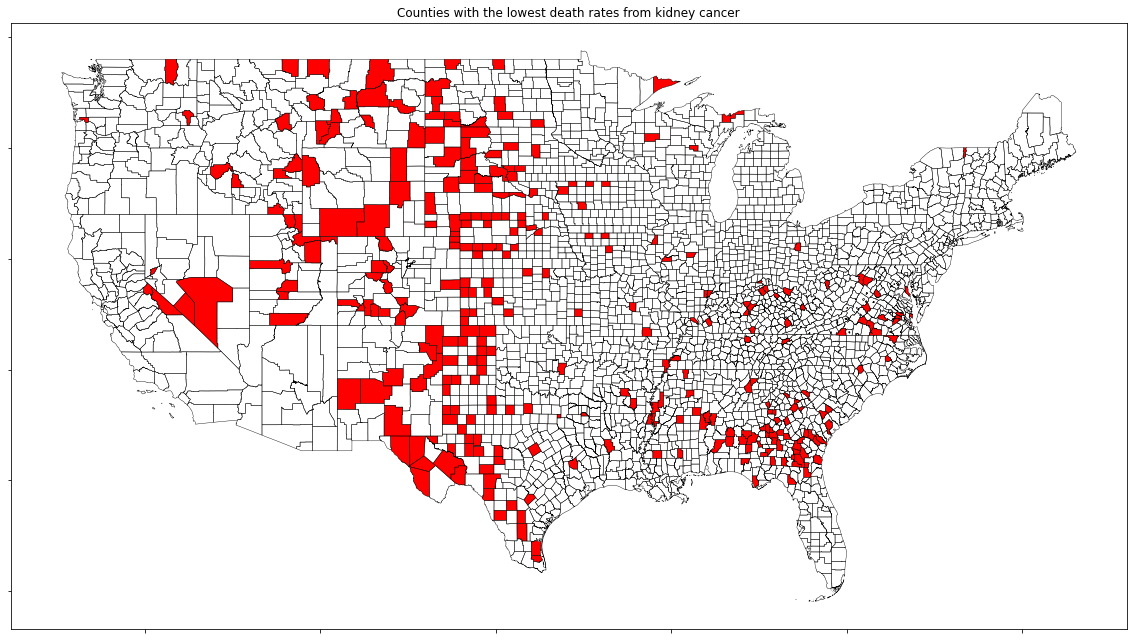

In [8]:
fig = plt.figure(figsize = (20,20))
ax = plt.axes()
counties.boundary.plot(ax=ax, color = 'black', lw=0.4)
lowest.plot(ax=ax, color = 'red')
plt.title('Counties with the lowest death rates from kidney cancer')
plt.tick_params(labelleft=False, labelbottom=False)
plt.savefig('lowest.png', bbox_inches = 'tight')

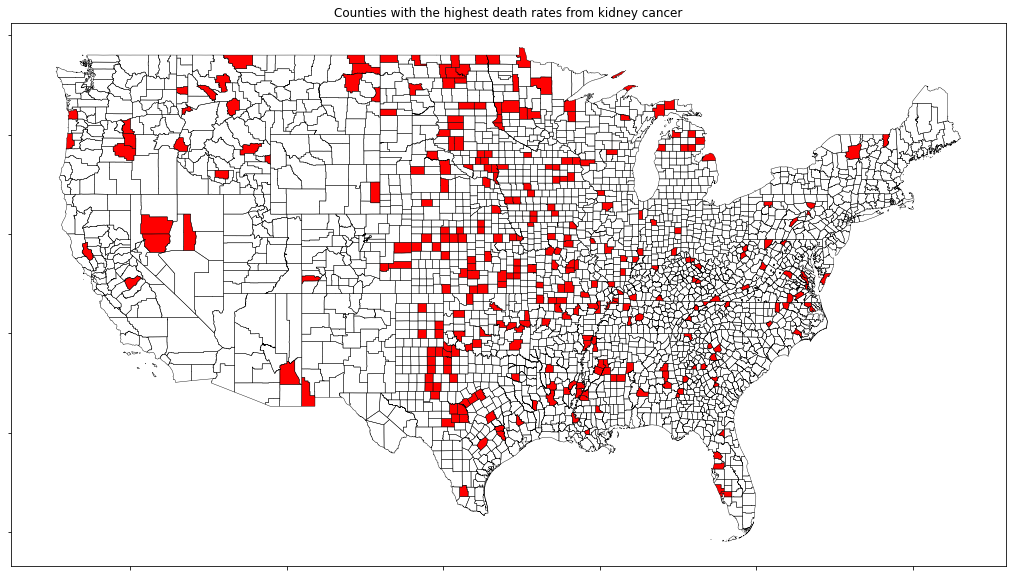

In [9]:
fig = plt.figure(figsize = (20,10))
ax = plt.axes()
counties.boundary.plot(ax=ax, color = 'black', lw=0.4)
highest.plot(ax=ax, color = 'red')
plt.title('Counties with the highest death rates from kidney cancer')
plt.tick_params(labelleft=False, labelbottom=False)
plt.savefig('highest.png', bbox_inches = 'tight')

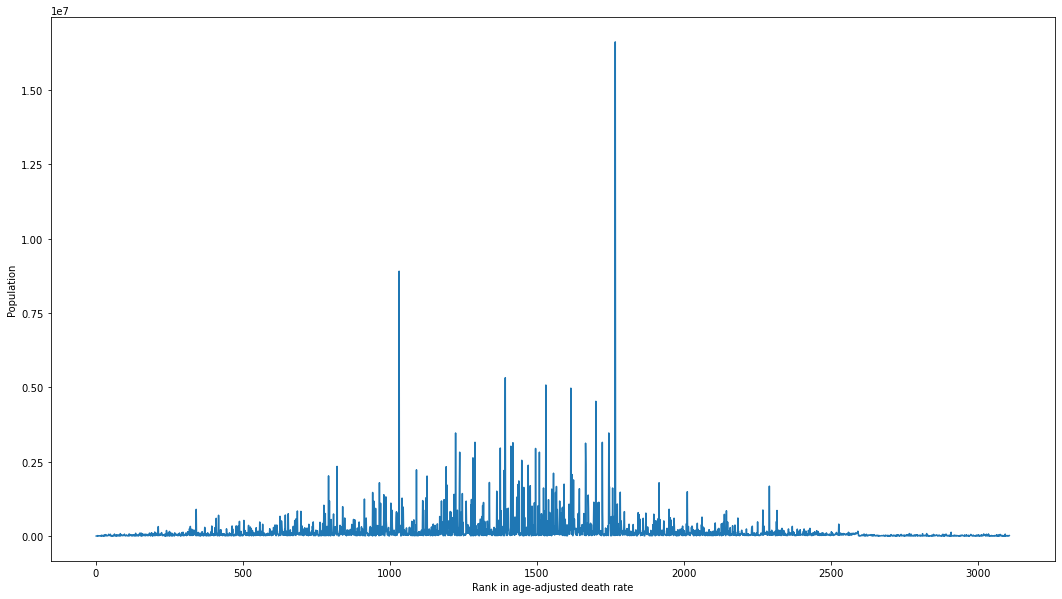

In [10]:
plt.figure(figsize=(18, 10))
plt.plot(np.arange(1, len(fulldata) + 1), fulldata.sort_values(by='aadc.2', ascending = False)['pop.2'])
plt.ylabel('Population')
plt.xlabel('Rank in age-adjusted death rate')
plt.show()

## Simulating the simplest possible model

A simple model just treats every county as a Poisson random variable with a common rate and exposure proportional to the population. Below, I run the simulation with a fixed rate of $5 \times 10^{-5}$, which is close to the observed national average. The "right" way to do this, of course, is to set a prior on the common $\theta$ and then update it with the data -- but this simple model is just here to show that the concentration of high- and low-death-rate counties we see above is a sample size effect, not an effect of varying rates.

In [11]:
# Generate death counts from a Poisson distribution
def simulate_deaths(theta, df):
    death_counts = [sp.stats.poisson.rvs(theta * n) for n in df['pop.2']]
    return np.array(death_counts)

In [12]:
raw_rate = fulldata['dc.2'].sum() / fulldata['pop.2'].sum()  # raw sample proportion for the entire country
deathrate = 1e5 * simulate_deaths(raw_rate, fulldata) / (fulldata['pop.2'].values) # 1e5 scales to deaths per 100,000, same as original data
deathrate[:10]

array([ 9.24285604,  4.09724819,  2.94230147,  3.20769848,  2.18467017,
       12.19958521,  6.30477271,  6.86633394,  5.18914431,  4.56329287])

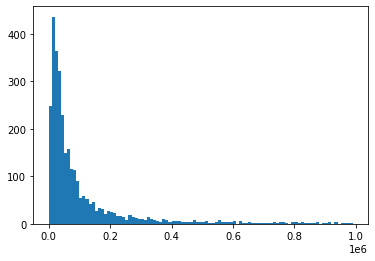

In [13]:
plt.hist(fulldata['pop.2'], bins = np.arange(0, 1e6, 1e4))
plt.show()

In [14]:
q10 = np.quantile(deathrate, 0.1)
q90 = np.quantile(deathrate, 0.9)

lowest = fulldata[deathrate <= q10]
highest = fulldata[deathrate >= q90]

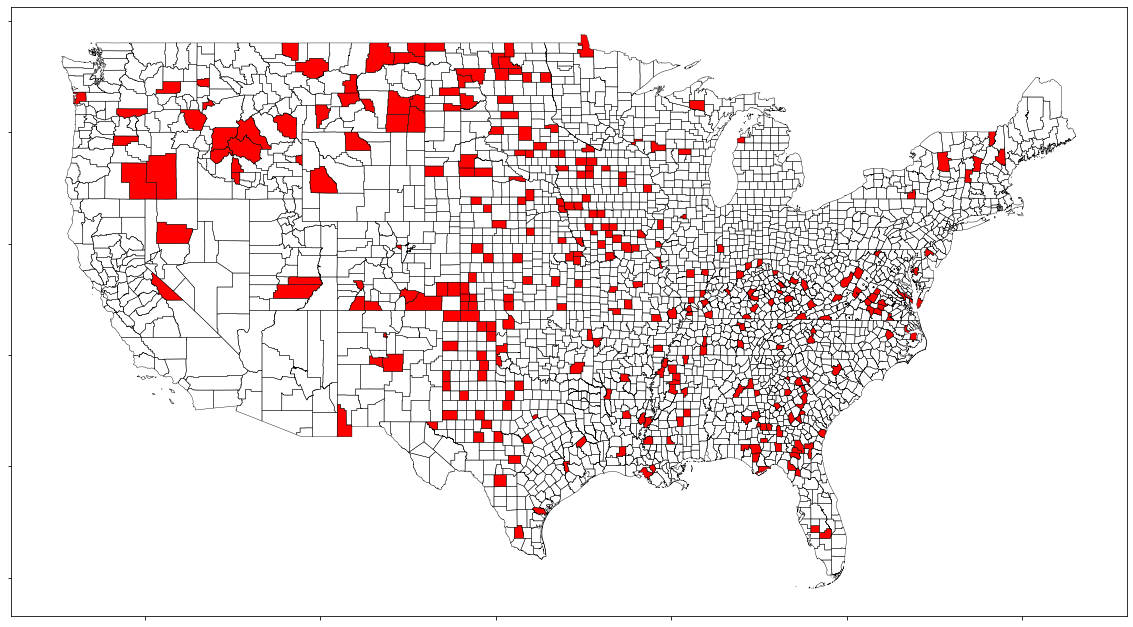

In [15]:
fig = plt.figure(figsize = (20,20))
ax = plt.axes()
counties.boundary.plot(ax=ax, color = 'black', lw=0.4)
highest.plot(ax=ax, color = 'red')
#plt.title('Counties with the highest death rates from kidney cancer')
plt.tick_params(labelleft=False, labelbottom=False)
plt.show()

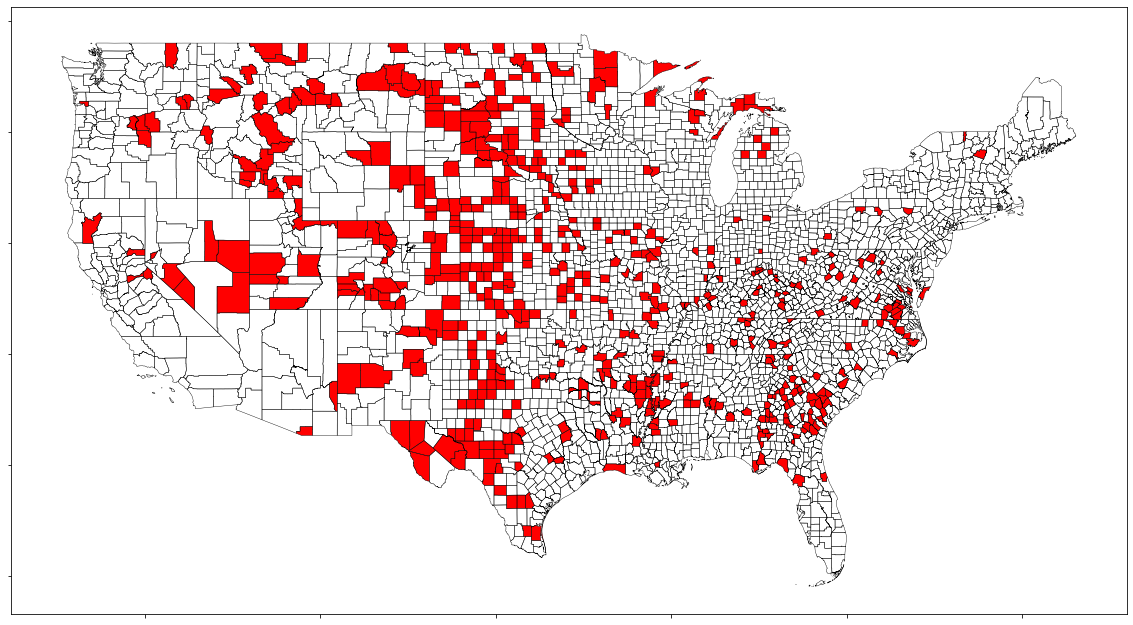

In [16]:
fig = plt.figure(figsize = (20,20))
ax = plt.axes()
counties.boundary.plot(ax=ax, color = 'black', lw=0.4)
lowest.plot(ax=ax, color = 'red')
#plt.title('Counties with the lowest death rates from kidney cancer')
plt.tick_params(labelleft=False, labelbottom=False)
plt.show()

Run a check using the rank plot from before:

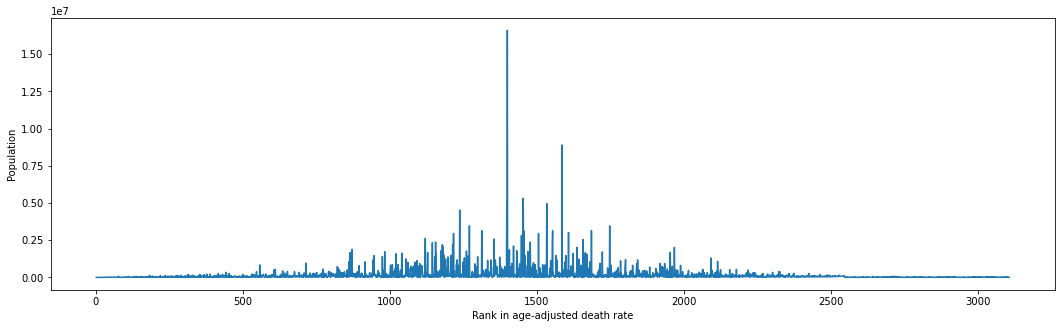

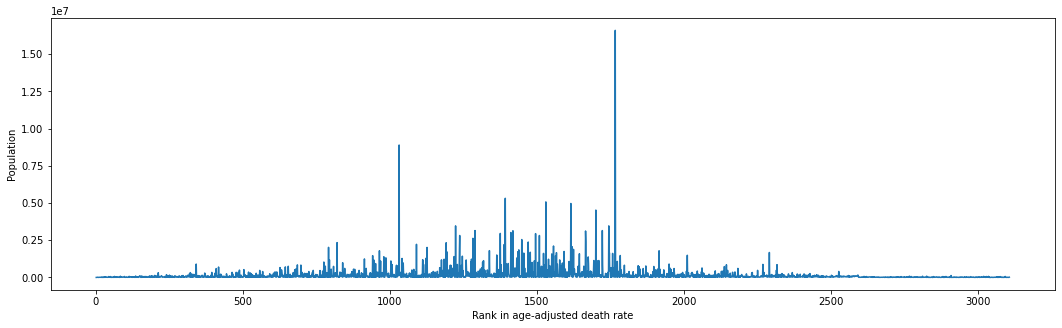

In [17]:
newdf = fulldata[['pop.2']].copy()
newdf['deathrate'] = deathrate

plt.figure(figsize=(18, 5))
plt.plot(np.arange(1, len(fulldata) + 1), newdf.sort_values(by='deathrate', ascending = False)['pop.2'])
plt.ylabel('Population')
plt.xlabel('Rank in age-adjusted death rate')
plt.show()
plt.figure(figsize=(18, 5))
plt.plot(np.arange(1, len(fulldata) + 1), fulldata.sort_values(by='aadc.2', ascending = False)['pop.2'])
plt.ylabel('Population')
plt.xlabel('Rank in age-adjusted death rate')
plt.show()

## A slightly more interesting model

In this model, we'll model all the counties separately. Each county gets its own $\theta_j$. The $\theta_j$ values are themselves drawn from a common $\mathrm{Gamma}(\alpha, \beta)$ distribution. We'll make a couple of ad hoc choices for $\alpha$ and $\beta$ below to try to replicate the analysis in BDA chapter 2 as closely as possible. Unfortunately, it's not easy to get an exact replication, and the author has [written that he doesn't remember exactly what adjustments he made](https://statmodeling.stat.columbia.edu/2009/11/01/just_to_disillu/). 

Gelman writes,
> When I have more time I will have to go back and clarify this.

However, it's been nearly 11 years since that post and as far as I could find he has not written anything more on it :). So, I made ad hoc choices of my own. It's instructive to play around with changes to the prior. I think as long as the prior mean is nearly $5 \times 10^{-5}$, you will get reasonably similar results. A more sophisticated approach, which we will learn about later in the course, is to use a hierarchical model structure to allow the prior to be set by the data.

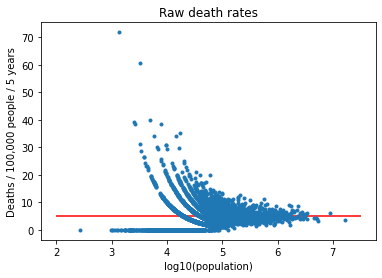

In [18]:
plt.plot(np.log10(fulldata['pop.2']), 1e5*fulldata['dc.2'] / (fulldata['pop.2']), '.')
plt.title('Raw death rates')
plt.ylabel('Deaths / 100,000 people / 5 years')
plt.xlabel('log10(population)')
plt.hlines(y=1e5*(sum(fulldata['dc.2']) / sum(fulldata['pop.2'])), xmin=2, xmax=7.5, color = 'red')
plt.show()

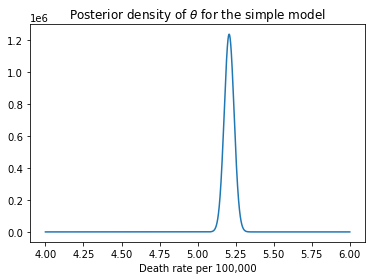

In [19]:
# Inference for the single-parameter model with Gamma(10, 100000 prior)
deaths = sum(fulldata['dc.2'])
pop = sum(fulldata['pop.2'])
x = np.linspace(4e-5, 6e-5, 10000)
y = sp.stats.gamma.pdf(x, a = deaths + 10, scale = 1/(pop + 100000))
plt.plot(1e5 * x, y)
plt.title('Posterior density of $\\theta$ for the simple model')
plt.xlabel('Death rate per 100,000')
plt.show()

In [20]:
# Posterior means county-by-county with a Gamma(10, 200000) prior
# The mean of Gamma(alpha, beta) is alpha / beta so we don't really need to do any calculations with the pdf.
fulldata['pmean'] = (10 + fulldata['dc.2']) / (200000 + fulldata['pop.2'])

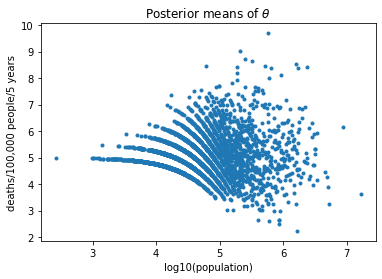

In [21]:
plt.plot(np.log10(fulldata['pop.2']), 1e5*fulldata['pmean'], '.')
plt.title('Posterior means of $\\theta$')
plt.xlabel('log10(population)')
plt.ylabel('deaths/100,000 people/5 years')
plt.show()

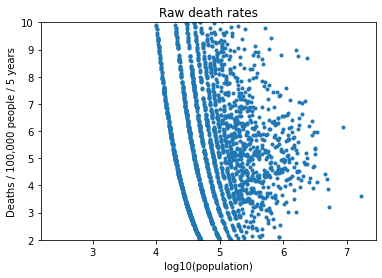

In [22]:
plt.plot(np.log10(fulldata['pop.2']), 1e5*fulldata['dc.2'] / (fulldata['pop.2']), '.')
plt.title('Raw death rates')
plt.ylabel('Deaths / 100,000 people / 5 years')
plt.ylim((2, 10))
plt.xlabel('log10(population)')
plt.show()

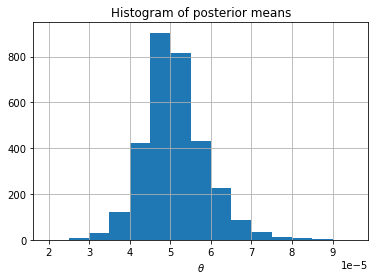

In [23]:
fulldata['pmean'].hist(bins=np.arange(2e-5, 1e-4, 5e-6))
plt.title('Histogram of posterior means')
plt.xlabel('$\\theta$')
plt.show()

In [24]:
q10 = np.quantile(fulldata['pmean'], 0.1)
q90 = np.quantile(fulldata['pmean'], 0.9)
lowest = fulldata[fulldata['pmean'] <= q10]
highest = fulldata[fulldata['pmean'] >= q90]

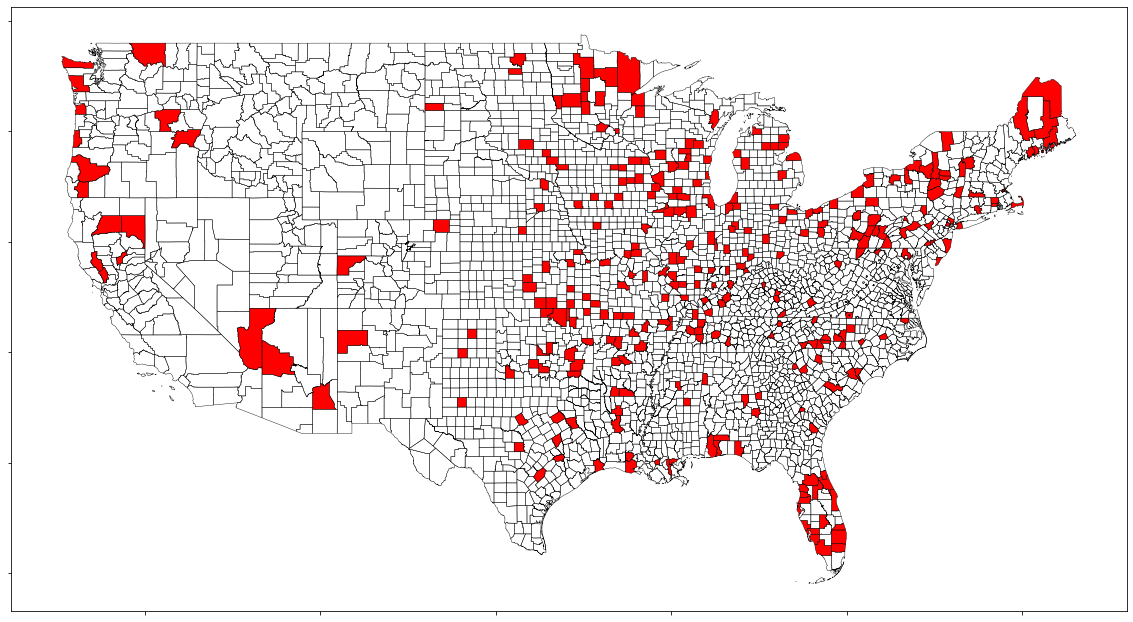

In [25]:
fig = plt.figure(figsize = (20,20))
ax = plt.axes()
counties.boundary.plot(ax=ax, color = 'black', lw=0.4)
highest.plot(ax=ax, color = 'red')
#plt.title('Counties with the lowest death rates from kidney cancer')
plt.tick_params(labelleft=False, labelbottom=False)
plt.show()

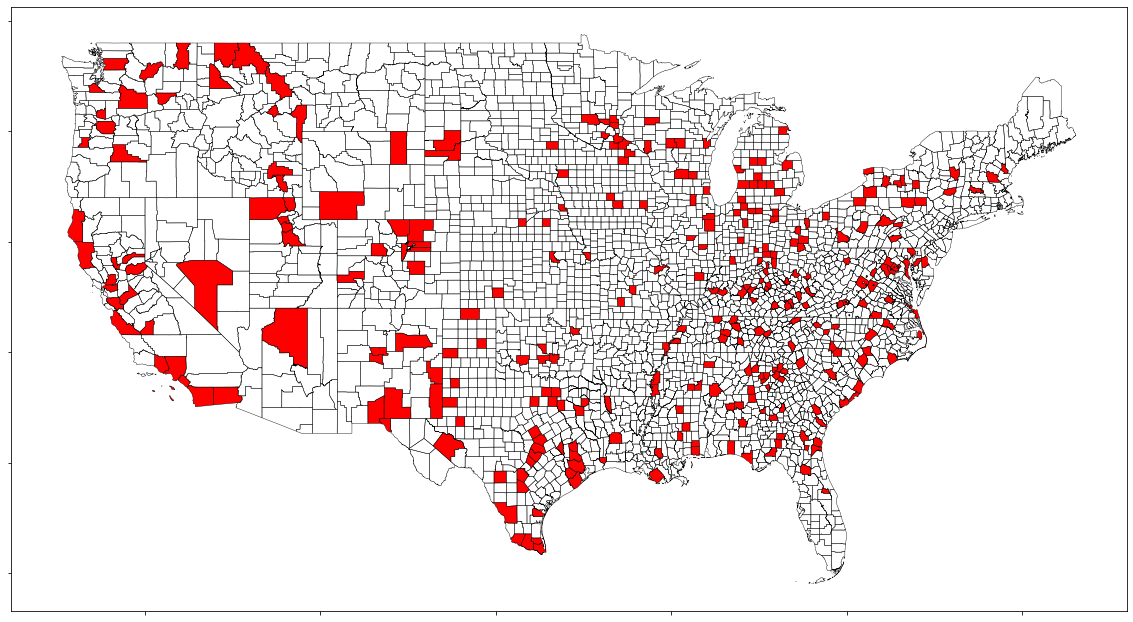

In [26]:
fig = plt.figure(figsize = (20,20))
ax = plt.axes()
counties.boundary.plot(ax=ax, color = 'black', lw=0.4)
lowest.plot(ax=ax, color = 'red')
#plt.title('Counties with the lowest death rates from kidney cancer')
plt.tick_params(labelleft=False, labelbottom=False)
plt.show()